# Vanilla AutoEncoder Example with CIFAR10

# Imports

In [1]:
import torch, torchvision, time
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
torch.manual_seed(547)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


# Configurations

In [2]:
EPOCHS = 15
BATCH_SIZE = 128
LR = 1e-3
WEIGHT_DECAY = 0
LATENT_DIM = 128

# Dataloader and Pre-processing

In [3]:
transform = transforms.Compose([transforms.ToTensor()])

train = datasets.CIFAR10(root="./data", train=True,  download=True, transform=transform)
test  = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test,  batch_size=BATCH_SIZE, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


# Data sample visualization

In [4]:
image, class_label = train[107]
input_shape = image.size()
print("input shape:", image.shape)

input shape: torch.Size([3, 32, 32])


In [5]:
# the default range of the torchvision image data is (0, 1)
image.min(), image.max()

(tensor(0.), tensor(0.9490))

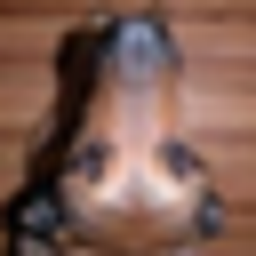

Class label 5


In [6]:
display(transforms.functional.to_pil_image(image).resize((256,256)))
print("Class label", class_label)

# Model

### Encoder

In [7]:
class encoder(nn.Module):
    def __init__(self, in_channel=3, channels=[16, 32]):
        super(encoder, self).__init__()
        channels = [in_channel] + channels
        self.downsample = nn.ModuleList()
        for i in range(1, len(channels)):
            self.downsample.extend([
                nn.Conv2d(in_channels=channels[i-1], out_channels=channels[i], kernel_size=3, stride=2, padding=1),
                nn.Conv2d(in_channels=channels[i], out_channels=channels[i], kernel_size=3, stride=1, padding=1),
            ])
            
        self.relu = nn.ReLU()
        
    def forward(self, x, verbose=0):
        if verbose:
            print(f"Encoder input shape: {x.shape}")
        
        for i, donwsample_layer in enumerate(self.downsample):
            x = donwsample_layer(x)
            x = self.relu(x)
            
            if verbose:
                print(f"Encoder layer_{i} output shape: {x.shape}")
        
        return x
        

### Decoder

In [8]:
class decoder(nn.Module):
    def __init__(self, out_channel=3, channels=[16, 32]):
        super(decoder, self).__init__()
        channels = [out_channel] + channels
        self.upsample = nn.ModuleList()
        for i in range(len(channels)-2, -1, -1):
             self.upsample.extend([
                 nn.ConvTranspose2d(in_channels=channels[i+1], out_channels=channels[i], kernel_size=3, stride=2, padding=1, output_padding=1),
                 nn.ConvTranspose2d(in_channels=channels[i], out_channels=channels[i], kernel_size=3, stride=1, padding=1, output_padding=0),
             ])
        
        self.relu = nn.ReLU()
        
    def forward(self, x, verbose=0):
        if verbose:
            print(f"Decoder input shape: {x.shape}")
        for i, upsample_layer in enumerate(self.upsample):
            x = upsample_layer(x)
            x = self.relu(x)
            
            if verbose:
                print(f"Decoder layer_{i} output shape: {x.shape}")
            
        return x

### AutoEncoder

In [9]:
class autoencoder(nn.Module):
    def __init__(self, inp_shape, latent_dim=128, channels=[32, 64]):
        super(autoencoder, self).__init__()
        self.downsample_size = (channels[-1],
                                inp_shape[1]//(2 ** len(channels)), 
                                inp_shape[2]//(2 ** len(channels)))
        
        self.encoder = encoder(in_channel=inp_shape[0], channels=channels)
        self.to_latent = nn.Linear(self.downsample_size[0] * self.downsample_size[1] * self.downsample_size[2],
                                   latent_dim)
        
        self.from_latent = nn.Linear(latent_dim,
                                     self.downsample_size[0] * self.downsample_size[1] * self.downsample_size[2])
        
        self.decoder = decoder(out_channel=inp_shape[0], channels=channels)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        
    def forward(self, x, verbose=0):
        latent = self.encode(x, verbose=verbose)
        rec = self.decode(latent, verbose=verbose)
        
        return rec
    
    def encode(self, x, verbose=0):
        x = self.encoder(x, verbose=verbose)
        assert x.shape[1:] == self.downsample_size, "Encoder output shape does not match downsample_size" 
        
        # flatten
        x = x.view(x.shape[0], -1)
        
        # project to latent dimension
        latent = self.to_latent(x)
        latent = self.relu(latent)
        return latent
    
    def decode(self, latent, verbose=0):
        # reshape to downsample size
        latent = self.from_latent(latent)
        latent = latent.reshape(latent.shape[0], *self.downsample_size)
        rec = self.decoder(latent, verbose=verbose)
        return rec

# Define model

In [10]:
model = autoencoder(input_shape, latent_dim=LATENT_DIM, channels=[16, 32, 64]).to(device)

# Test model on random data

In [11]:
input_shape

torch.Size([3, 32, 32])

In [12]:
sample_input = torch.rand((4, 3, 32, 32), dtype=torch.float32).to(device)
reconsturction = model(sample_input, verbose=1)

Encoder input shape: torch.Size([4, 3, 32, 32])
Encoder layer_0 output shape: torch.Size([4, 16, 16, 16])
Encoder layer_1 output shape: torch.Size([4, 16, 16, 16])
Encoder layer_2 output shape: torch.Size([4, 32, 8, 8])
Encoder layer_3 output shape: torch.Size([4, 32, 8, 8])
Encoder layer_4 output shape: torch.Size([4, 64, 4, 4])
Encoder layer_5 output shape: torch.Size([4, 64, 4, 4])
Decoder input shape: torch.Size([4, 64, 4, 4])
Decoder layer_0 output shape: torch.Size([4, 32, 8, 8])
Decoder layer_1 output shape: torch.Size([4, 32, 8, 8])
Decoder layer_2 output shape: torch.Size([4, 16, 16, 16])
Decoder layer_3 output shape: torch.Size([4, 16, 16, 16])
Decoder layer_4 output shape: torch.Size([4, 3, 32, 32])
Decoder layer_5 output shape: torch.Size([4, 3, 32, 32])


# Loss and Optimizer

In [13]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,10,12,15], gamma=0.1)

# Visalize latent space before training

/kuacc/users/mali18/.conda/envs/taming-default/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/kuacc/users/mali18/.conda/envs/taming-default/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6400 samples in 0.001s...
[t-SNE] Computed neighbors for 6400 samples in 1.253s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6400
[t-SNE] Computed conditional probabilities for sample 2000 / 6400
[t-SNE] Computed conditional probabilities for sample 3000 / 6400
[t-SNE] Computed conditional probabilities for sample 4000 / 6400
[t-SNE] Computed conditional probabilities for sample 5000 / 6400
[t-SNE] Computed conditional probabilities for sample 6000 / 6400
[t-SNE] Computed conditional probabilities for sample 6400 / 6400
[t-SNE] Mean sigma: 0.000846
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.587753
[t-SNE] KL divergence after 1000 iterations: 2.786667


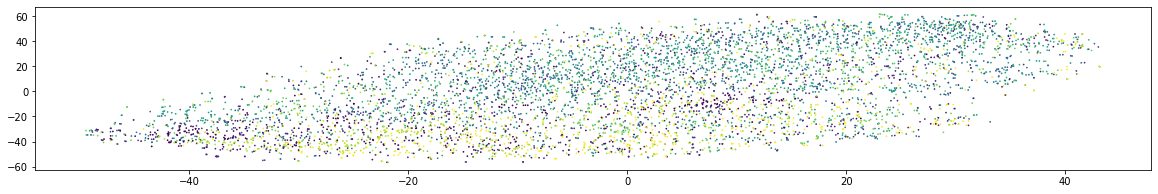

In [16]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import itertools
%matplotlib inline

latents = []
classes = [] 
with torch.no_grad():
    for images, cls_labels in itertools.islice(train_loader, 50):
        images = images.to(device)
        latents.extend(model.encode(images).cpu().numpy())
        classes.extend(cls_labels.numpy())


# project to 2d for visualization
embed = TSNE(n_components = 2, verbose=True)
Y = embed.fit_transform(latents)

fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(Y[:,0], Y[:,1], c = classes, s = 0.5)

# Training

In [17]:
from tqdm import tqdm
outputs = []
losses = []
for epoch in tqdm(range(EPOCHS)):
    running_train_loss = 0
    start_time = time.time()
    for image, cls_label in train_loader:
        image, _ = image.to(device), cls_label.to(device)
        
        output = model(image)
        loss = criterion(output, image)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
        
    outputs.append((epoch+1, image[0], output[0]))
    loss = running_train_loss / len(train_loader)
    losses.append(loss)
    end_time = time.time()
    #scheduler.step()
    print(f"Epoch [{epoch+1}/{EPOCHS}], loss:{loss:.4f} in {(end_time-start_time):.2f}s")

  7%|▋         | 1/15 [00:22<05:18, 22.77s/it]

Epoch [1/15], loss:0.0550 in 22.77s


 13%|█▎        | 2/15 [00:44<04:51, 22.44s/it]

Epoch [2/15], loss:0.0213 in 22.21s


 20%|██        | 3/15 [01:06<04:23, 21.93s/it]

Epoch [3/15], loss:0.0181 in 21.32s


 27%|██▋       | 4/15 [01:28<04:04, 22.20s/it]

Epoch [4/15], loss:0.0163 in 22.61s


 33%|███▎      | 5/15 [01:51<03:43, 22.31s/it]

Epoch [5/15], loss:0.0137 in 22.51s


 40%|████      | 6/15 [02:08<03:05, 20.59s/it]

Epoch [6/15], loss:0.0128 in 17.25s


 47%|████▋     | 7/15 [02:24<02:32, 19.02s/it]

Epoch [7/15], loss:0.0121 in 15.79s


 53%|█████▎    | 8/15 [02:42<02:10, 18.60s/it]

Epoch [8/15], loss:0.0115 in 17.71s


 60%|██████    | 9/15 [02:57<01:45, 17.60s/it]

Epoch [9/15], loss:0.0112 in 15.38s


 67%|██████▋   | 10/15 [03:15<01:27, 17.59s/it]

Epoch [10/15], loss:0.0108 in 17.57s


 73%|███████▎  | 11/15 [03:30<01:07, 16.99s/it]

Epoch [11/15], loss:0.0105 in 15.62s


 80%|████████  | 12/15 [03:45<00:49, 16.37s/it]

Epoch [12/15], loss:0.0103 in 14.95s


 87%|████████▋ | 13/15 [04:02<00:32, 16.36s/it]

Epoch [13/15], loss:0.0101 in 16.35s


 93%|█████████▎| 14/15 [04:17<00:16, 16.11s/it]

Epoch [14/15], loss:0.0100 in 15.53s


100%|██████████| 15/15 [04:33<00:00, 18.23s/it]

Epoch [15/15], loss:0.0097 in 15.84s


# Evaluation

loss: 0.00959
Original Images


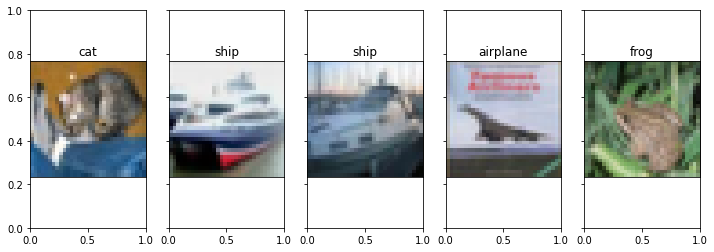

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Reconstructed Images


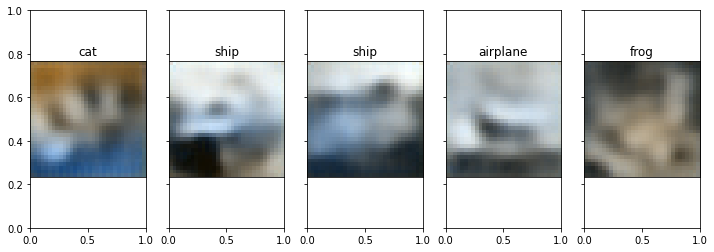

In [18]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
#Batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

#Sample outputs
output = model(images.to(device))
print(f"loss: {criterion(images.to(device), output.to(device)):.5f}")
images = images.permute(0, 2, 3, 1).numpy()
output = output.cpu().permute(0, 2, 3, 1).detach().numpy()
#Original Images
print("Original Images")
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in range(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(images[idx])
    ax.set_title(classes[labels[idx]])
plt.show()

#Reconstructed Images
print('Reconstructed Images')
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in range(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(output[idx])
    ax.set_title(classes[labels[idx]])
plt.show() 

# Latent space visualization

In [19]:
import itertools
latents = []
classes = [] 
with torch.no_grad():
    for images, cls_labels in itertools.islice(train_loader, 50):
        images = images.to(device)
        latents.extend(model.encode(images).cpu().numpy())
        classes.extend(cls_labels.numpy())

/kuacc/users/mali18/.conda/envs/taming-default/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/kuacc/users/mali18/.conda/envs/taming-default/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6400 samples in 0.002s...
[t-SNE] Computed neighbors for 6400 samples in 1.360s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6400
[t-SNE] Computed conditional probabilities for sample 2000 / 6400
[t-SNE] Computed conditional probabilities for sample 3000 / 6400
[t-SNE] Computed conditional probabilities for sample 4000 / 6400
[t-SNE] Computed conditional probabilities for sample 5000 / 6400
[t-SNE] Computed conditional probabilities for sample 6000 / 6400
[t-SNE] Computed conditional probabilities for sample 6400 / 6400
[t-SNE] Mean sigma: 2.361001
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.976990
[t-SNE] KL divergence after 1000 iterations: 2.518783


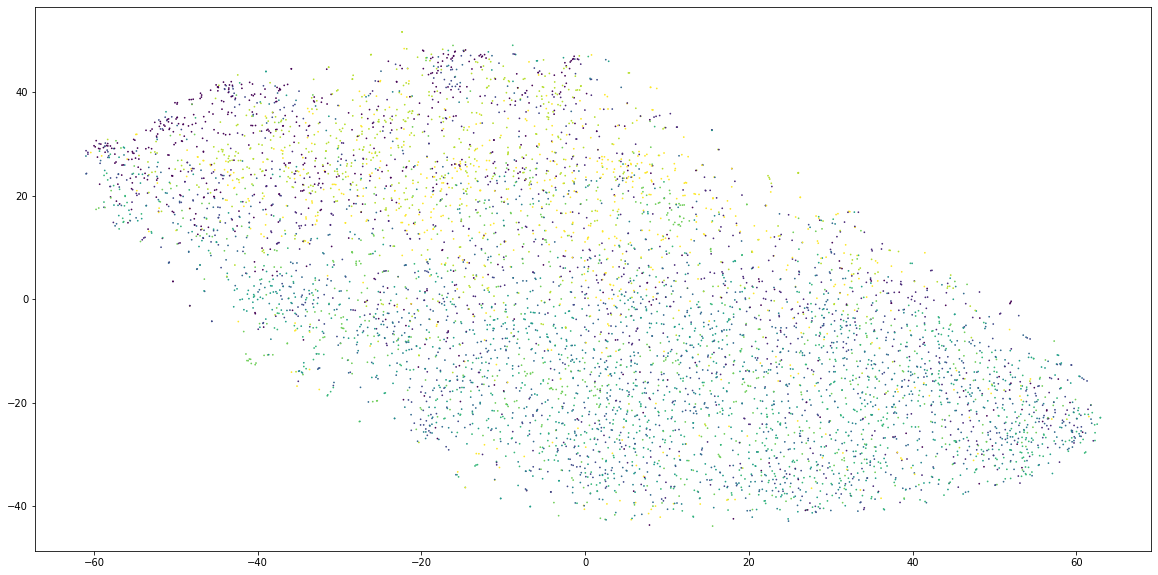

In [21]:
# visualize the embedding space
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE
# project to 2d for visualization
embed = TSNE(n_components = 2, verbose=True)
Y = embed.fit_transform(latents)
fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(Y[:,0], Y[:,1], c = classes, s = 0.5)